In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading the Dataset

In [29]:
def load_images(path):
    with open(path, 'rb') as f:
        # Read the first 16 bytes which contain metadata
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=np.dtype('>i4'), count=4)
        # Read the remaining bytes which contain the image data
        images = np.frombuffer(f.read(), dtype=np.dtype('>u1')).reshape(num, rows, cols)
    return images

def load_labels(path):
    with open(path, 'rb') as f:
        # Read the first 8 bytes which contain metadata
        magic, num = np.frombuffer(f.read(8), dtype=np.dtype('>i4'), count=2)
        # Read the remaining bytes which contain the label data
        labels = np.frombuffer(f.read(), dtype=np.dtype('>u1'))
    return labels

# Paths to the downloaded files
train_images_path = 'train-images.idx3-ubyte'
train_labels_path = 'train-labels.idx1-ubyte'
test_images_path = 't10k-images.idx3-ubyte'
test_labels_path = 't10k-labels.idx1-ubyte'

# Load the datasets
train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)

# Checking if the data is loaded correctly
print(f'Training images shape: {train_images.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


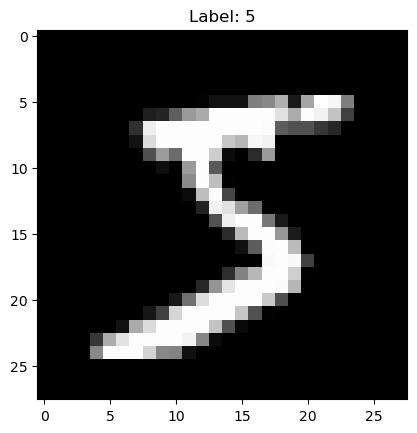

In [35]:
def convert_to_dataframe(images, labels):
    # Flatten the images array from (num_samples, 28, 28) to (num_samples, 784)
    flattened_images = images.reshape(images.shape[0], -1)
    # Create a DataFrame with the flattened images
    df = pd.DataFrame(flattened_images)
    # Add the labels as a new column
    df['label'] = labels
    return df

# Convert training and test sets to DataFrames
train_df = convert_to_dataframe(train_images, train_labels)
test_df = convert_to_dataframe(test_images, test_labels)

def plot_image(image, label):
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()

# Plot the first image in the training set
plot_image(train_images[0], train_labels[0])


In [33]:
# Display the first few rows of the training DataFrame
print(train_df.head())

# Describe the DataFrame to see basic statistics
print(train_df.describe())

   0  1  2  3  4  5  6  7  8  9  ...  775  776  777  778  779  780  781  782  \
0  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
1  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
2  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
3  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
4  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   

   783  label  
0    0      5  
1    0      0  
2    0      4  
3    0      1  
4    0      9  

[5 rows x 785 columns]
             0        1        2        3        4        5        6        7  \
count  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0  60000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0